# Baseline implementation
This notebook implement the prediction of hypotension using the last mean artrial pressure (MAP) value. It is use as a baseline to compare with other models.

In [9]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_curve

In [10]:
HALF_TIME_FILTERING = 10 # secondes
FEATURE_NAME = "dbp"

In [11]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/base_dataset/cases/'))

static = pd.read_parquet('data/datasets/base_dataset/meta.parquet')

data = data.merge(static, on='caseid')

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)
    

train = data[data['split'] == 1]
test = data[data['split'] == 0]

test set contains 38537 sample with a prevalence of 4.1440693359628415% 
train set contains 90499 sample with a prevalence of 4.0807080741223665%


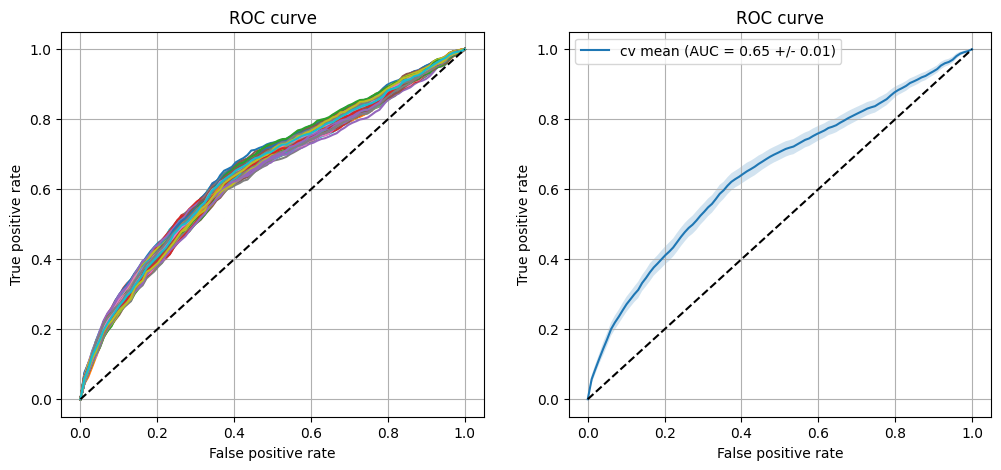

AUC = 0.65  [0.63, 0.66]
Sensitivity = 62.00  [59.05, 64.95] %
Specificity = 63.05  [61.01, 65.09] %
PPV = 6.76  [6.30, 7.21] %
NPV = 97.46  [97.26, 97.67] %


In [12]:
# for each subgoup of data, create a regressor and evaluate it
n_bootstraps = 200
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)


tpr_list, auc_list, thresh_list  = [], [], []
sensitivity_list, specificity_list, ppv_list, npv_list = [], [], [], []

fpr = np.linspace(0, 1, 100)

# create a regressor
print(f"test set contains {len(test)} sample with a prevalence of {test['label'].mean()*100}% ")
print(f"train set contains {len(train)} sample with a prevalence of {train['label'].mean()*100}%")

test = test.dropna(subset=[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'])

x_test = test[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
y_test = test['label'].values
y_pred = 1 - x_test/120

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    fpr_, tpr_, tr_ = roc_curve(y_test[indices], y_pred[indices])
    auc_ = auc(fpr_, tpr_)
    gmean = np.sqrt(tpr_ * (1-fpr_))
    id_thresh_opt = np.argmax(gmean)
    sensitivity_list.append(tpr_[id_thresh_opt]*100)
    specificity_list.append((1-fpr_[id_thresh_opt])*100)
    prevalence = np.mean(y_test[indices])
    ppv_list.append(100 * tpr_[id_thresh_opt]*prevalence / (tpr_[id_thresh_opt]*prevalence + fpr_[id_thresh_opt]*(1-prevalence)))
    npv_list.append(100 * (1-fpr_[id_thresh_opt])*(1-prevalence) / ((1-tpr_[id_thresh_opt])*prevalence + (1-fpr_[id_thresh_opt])*(1-prevalence)))


    tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tpr_))
    thresh_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tr_))
    auc_list.append(auc_)  

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr_list)):
    plt.plot(fpr, tpr_list[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
tpr_mean = np.mean(tpr_list, axis=0)
tpr_std = np.std(tpr_list, axis=0)
thr_mean = np.mean(thresh_list, axis=0)
sensi_mean = np.mean(sensitivity_list)
speci_mean = np.mean(specificity_list)
ppv_mean = np.mean(ppv_list)
npv_mean = np.mean(npv_list)
sensi_std = np.std(sensitivity_list)
speci_std = np.std(specificity_list)
ppv_std = np.std(ppv_list)
npv_std = np.std(npv_list)

plt.fill_between(fpr, tpr_mean - 2*tpr_std, tpr_mean + 2*tpr_std, alpha=0.2)
plt.plot(fpr, tpr_mean, label=f'cv mean (AUC = {np.mean(auc_list):.2f} +/- {pd.Series(auc_list).std():.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

# save data into a csv file
df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr_mean,
    'tpr_std': tpr_std,
    'threshold': thr_mean,
    'auc': np.mean(auc_list),
    'auc_std': pd.Series(auc_list).std(),
    'sensitivity': sensi_mean,
    'sensitivity_std': sensi_std,
    'specificity': speci_mean,
    'specificity_std': speci_std,
    'ppv': ppv_mean,
    'ppv_std': ppv_std,
    'npv': npv_mean,
    'npv_std': npv_std
})
df.to_csv('data/results/baseline_roc.csv', index=False)

print(f"AUC = {np.mean(auc_list):.2f}  [{np.mean(auc_list) - pd.Series(auc_list).std()*2:.2f}, {np.mean(auc_list) + pd.Series(auc_list).std()*2:.2f}]")
print(f"Sensitivity = {sensi_mean:.2f}  [{sensi_mean - sensi_std*2:.2f}, {sensi_mean + sensi_std*2:.2f}] %")
print(f"Specificity = {speci_mean:.2f}  [{speci_mean - speci_std*2:.2f}, {speci_mean + speci_std*2:.2f}] %")
print(f"PPV = {ppv_mean:.2f}  [{ppv_mean - ppv_std*2:.2f}, {ppv_mean + ppv_std*2:.2f}] %")
print(f"NPV = {npv_mean:.2f}  [{npv_mean - npv_std*2:.2f}, {npv_mean + npv_std*2:.2f}] %")


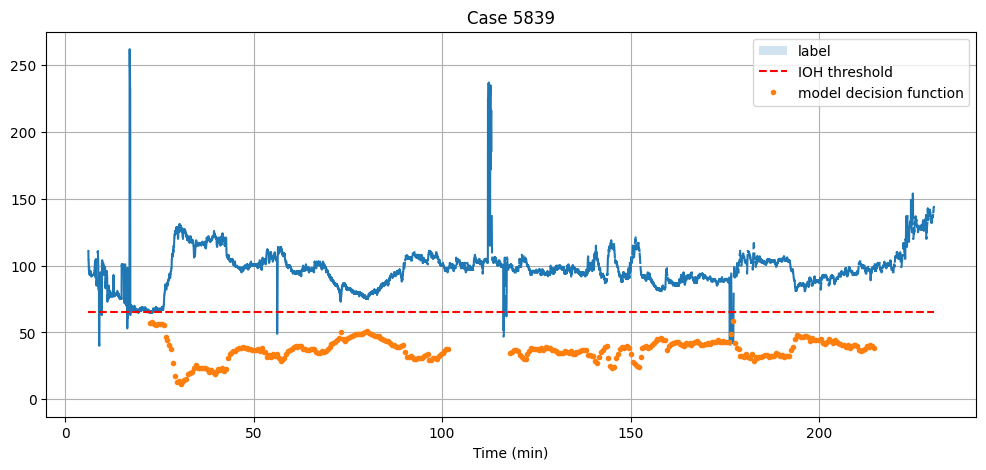

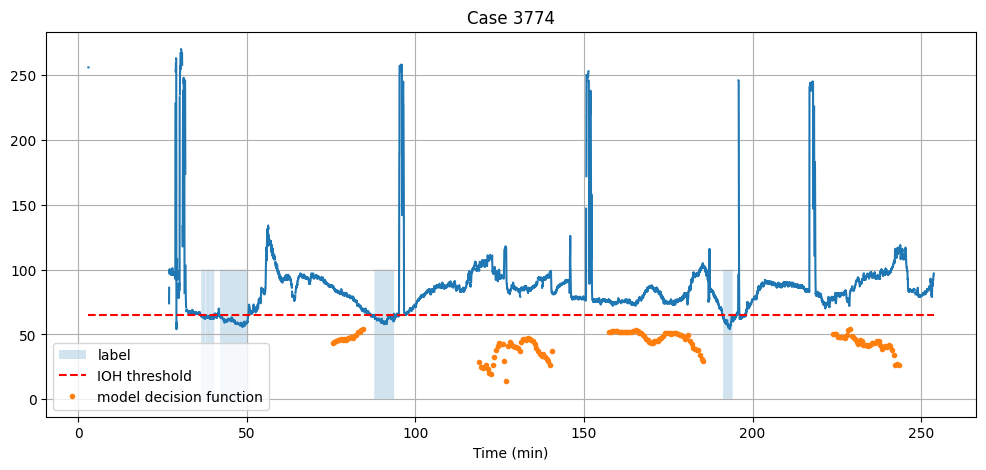

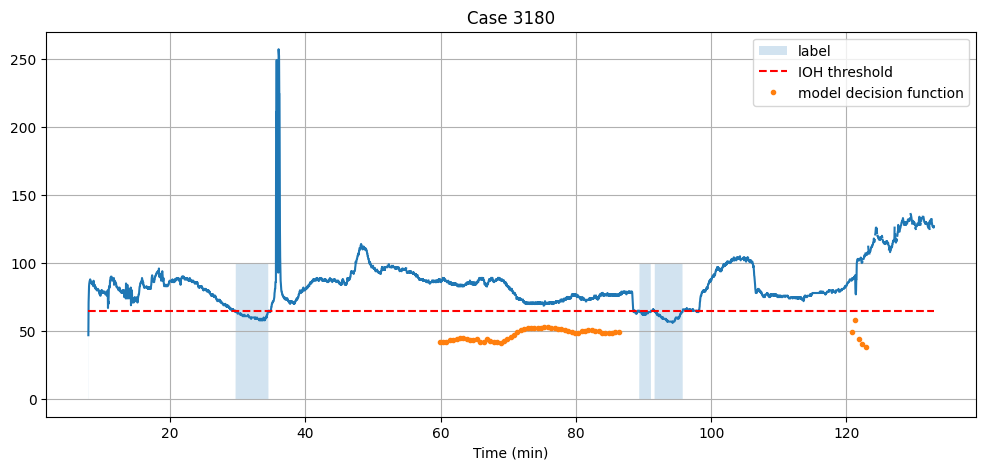

In [16]:
# plot 3 random cases with the corresponding decision function
from scripts.dataLoader import label_caseid

np.random.seed(10)
cases = np.random.choice(test['caseid'].unique(), 3, replace=False)

for case in cases:
    raw_case = pd.read_parquet(f'data/cases/case-{case:04d}.parquet')
    raw_case.rename(columns={'Solar8000/ART_MBP': 'mbp'}, inplace=True)
    raw_case.mbp.mask(raw_case.mbp < 40, inplace=True)
    # removing the nan values at the beginning and the ending
    case_valid_mask = ~raw_case.mbp.isna()
    raw_case = raw_case[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]

    raw_case.Time = pd.to_timedelta(raw_case.Time, unit="s")
    raw_case.set_index('Time', inplace=True)
    raw_case = raw_case.resample('2s').ffill()
    raw_case= label_caseid(raw_case, 2)

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'])
    x_test = segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
    y_test = segment_data['label'].values
    y_pred = 1 - x_test/120

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds/60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    plt.plot(raw_case.index.seconds/60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')
    plt.plot(segment_data['time'] / np.timedelta64(1, 's') /60,y_pred*100, '.', label='model decision function')
    # plt.plot(segment_data['time']/60, segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'], '*', label='label')
    plt.xlabel('Time (min)')
    # plt.xlim([100, 120])
    # plt.xlim([235, 245])
    # plt.ylim([42, 80])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()

